In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
from pathlib import Path

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
minutes_per_day = 1440 
trading_days_per_year = 365 

In [3]:
def process_csv(path):
    
    df_init = pd.read_csv(path)
    df_init.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
    df_init.set_index('time', inplace=True)
    df_init.index = pd.to_datetime(df_init.index, unit='ms')
    df = df_init[['close']].copy()
    pa = np.array([df['close'].values]) 
    pa[0,:] = pa[0,:] - (pa[0,-1] - pa[0,0])*np.linspace(0,1,minutes_per_day-1)
    pa[0,:] = pa[0,:]/pa[0,0]*3000.
    
    return pa

In [4]:
pas = []
vols = []

pathlist = Path('data/ETHUSDC/daily/').glob('**/*.csv')
for path in pathlist:
    path_in_str = str(path)  
    #print(path_in_str)
    pa = process_csv(path_in_str)
    dif = np.diff(np.log(pa[0,:]))
    intraday_variance = np.var(dif)
    vols.append( np.sqrt(intraday_variance * minutes_per_day * trading_days_per_year) )
    pas.append(pa)
    
vols = np.array(vols)
sorted_indices = np.argsort(vols)
vols = vols[sorted_indices]
pas = np.array(pas)[sorted_indices]

In [5]:
plt.show()
plt.rcParams["figure.figsize"] = [16, 9]

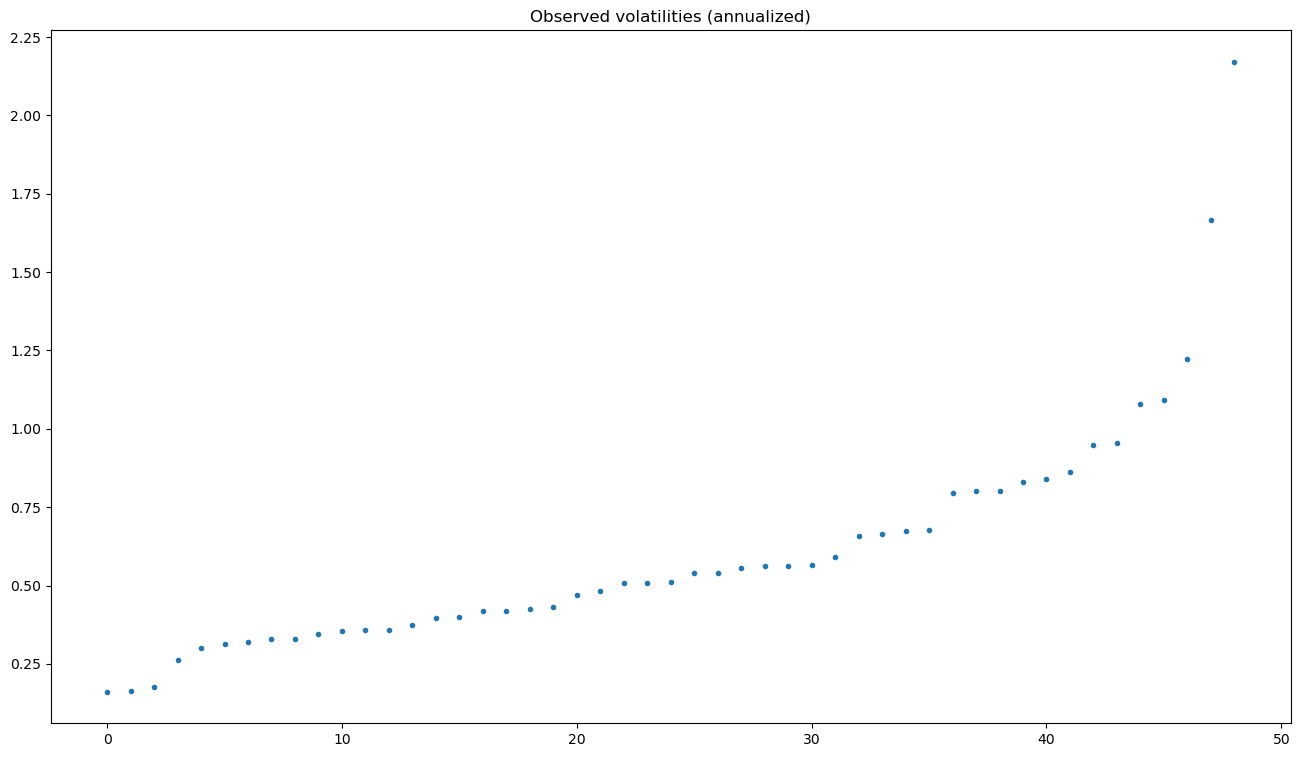

In [6]:
plt.plot(vols, '.')
plt.title('Observed volatilities (annualized)')
plt.show()

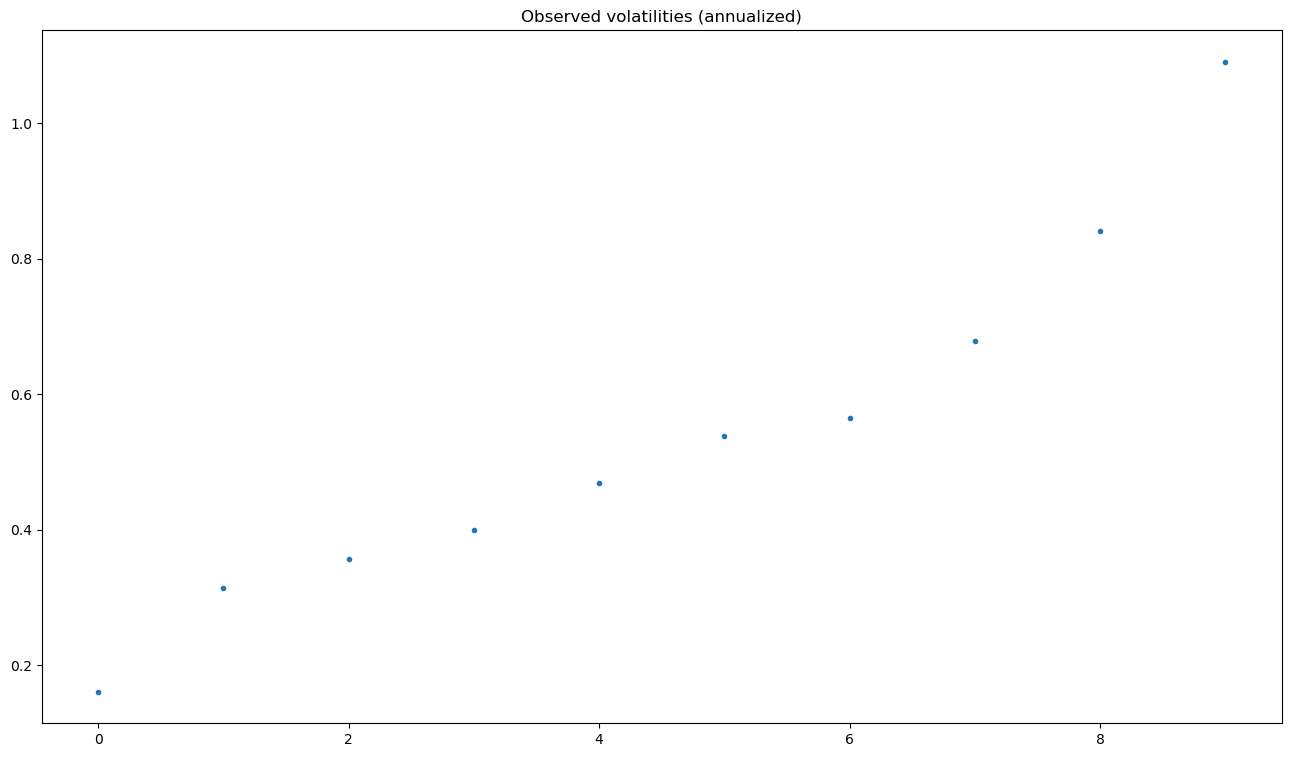

In [7]:
filt = 5
plt.plot(vols[::filt], '.')
plt.title('Observed volatilities (annualized)')
plt.show()

In [8]:
vols = vols[::filt]
pas = pas[::filt]

In [9]:
# Market Functions

def CPMM_Price(X, Y, D):
    
    return X/(Y-D)

def CPMM_Marginal_Price(X, Y):
    
    return X/Y

def CPMM_Update(X, Y, D):
    
    P = CPMM_Price(X, Y, D)
    
    return [X + P * D, Y - D]

def CEX_Price_Update(S, mu, sigma, dt, dW):
    
    return S * np.exp((mu-0.5*sigma**2)*dt + sigma*dW)

def Arb_Trade_CPMM(S, X, Y, eta0, eta1, M=1):
    
    D_A = np.zeros(M)
    
    P = CPMM_Marginal_Price(X, Y)
    
    q1 = np.minimum(Y * (1 - np.sqrt((P * (1 - eta1))/(S * (1 + eta0)))), 0.)
    q2 = np.maximum(Y * (1 - np.sqrt((P * (1 + eta1))/(S * (1 - eta0)))), 0.)
    
    D_A = q1 + q2
    
    return D_A

def Buy_Trade_CPMM(buy, S, X, Y, eta0, eta1):
    
    P = CPMM_Marginal_Price(X, Y)
    
    v = Y * (1 - np.sqrt((P * (1 + eta1))/(S * (1 + eta0))))
    
    return np.maximum(np.minimum(buy, v), 0.)
        
def Sell_Trade_CPMM(sell, S, X, Y, eta0, eta1):
    
    P = CPMM_Marginal_Price(X, Y)
    
    v = Y * (1 - np.sqrt((P * (1 - eta1))/(S * (1 - eta0))))

    return np.minimum(np.maximum(sell, v), 0.)

In [10]:
def simulation_realprice(M_, N_, T_, dt_, prices_array, buy_, sell_, noise_, eta0_, eta1_, X_, Y_, seed=42):

    np.random.seed(seed)
    # Initialize Vectors
    
    M = M_ #np.shape(prices_array)[0]
    N = N_# Number of periods
    
    S_ = prices_array.T[0]
    
    Pool_X = np.zeros((N+1, M)) # Time series for X pool reserves
    Pool_Y = np.zeros((N+1, M)) # Time series for Y pool reserves
    S0 = np.tile(prices_array[0][:, np.newaxis], (1, M))#prices_array.T
    S1 = np.zeros((N+1, M)) # Time series for CPMM price
    Arb = np.zeros((N+1, M)) # Time series of arbitrageur transactions
    CPMM_buy = np.zeros((N+1, M)) # Time series for systematic purchases on CPMM
    CPMM_sell = np.zeros((N+1, M)) # Time series for systematic sales on CPMM
    CPMM_noise = np.zeros((N+1, M)) # Time series for systematic net zero noise volume on CPMM
    CPMM_buy_revenue = np.zeros((N+1, M)) # Time series for buy trade revenue
    CPMM_sell_revenue = np.zeros((N+1, M)) # Time series for sell trade revenue
    CPMM_arb_revenue = np.zeros((N+1, M)) # Time series for arbitrage trade revenue
    CPMM_noise_revenue = np.zeros((N+1, M)) # Time series for noise trade revenue
    tracking_port_val = np.zeros((N+1, M)) # Time series for tracking portfolio value
    
    avg_buy_fee_rev = 0
    avg_sell_fee_rev = 0
    avg_arb_fee_rev = 0
    avg_imp_loss = 0
    avg_buy_volume = 0 
    avg_sell_volume = 0
    avg_arb_volume = 0
    avg_noise_fee_rev = 0
    avg_noise_volume = 0
            
    T = T_ # Time horizon
    dt = dt_ # Time increment
    buy = buy_ # Constant trade size for systematic buyers
    sell = sell_ # Constant trade size for systematic sellers
    eta0 = eta0_ # CEX proportional cost
    eta1 = eta1_ # CPMM proportional cost
    S = S_*np.ones(M) # Initial CEX Price
    X = X_*np.ones(M) # Initial CPMM Dollar Reserves
    Y = Y_*np.ones(M) # Initial CPMM Asset Reserves
    D_N = noise_

    S0[0] = S_
    S1[0] = CPMM_Marginal_Price(X, Y)
    Pool_X[0] = X
    Pool_Y[0] = Y
    tracking_port_val[0] = Pool_X[0] + Pool_Y[0] * S0[0]
        
    uni = np.random.uniform(0, 1, size=(N+1, M))
    filtr_bfs = uni < 0.5
    filtr_sfs = uni >= 0.5

    for i in range(1,N+1):

        S = S0[i]

        S1[i] = CPMM_Marginal_Price(X, Y)
        Pool_X[i] = X
        Pool_Y[i] = Y

        D_A = Arb_Trade_CPMM(S, X, Y, eta0, eta1, M)

        P = CPMM_Price(X, Y, D_A)

        [X, Y] = CPMM_Update(X, Y, D_A)

        S1[i] = CPMM_Marginal_Price(X, Y)
        Pool_X[i] = X
        Pool_Y[i] = Y
        Arb[i] = D_A 
        CPMM_arb_revenue[i] = np.abs(D_A * P * eta1)

            
        filtr_bf = filtr_bfs[i]
        filtr_sf = filtr_sfs[i]

        S_bf = S[filtr_bf]
        X_bf = X[filtr_bf]
        Y_bf = Y[filtr_bf]

        D_B = Buy_Trade_CPMM(buy, S_bf, X_bf, Y_bf, eta0, eta1)

        P = CPMM_Price(X_bf, Y_bf, D_B)

        [X_bf, Y_bf] = CPMM_Update(X_bf, Y_bf, D_B)

        S1[i, filtr_bf] = CPMM_Marginal_Price(X_bf, Y_bf)
        X[filtr_bf] = X_bf.copy()
        Y[filtr_bf] = Y_bf.copy()
        Pool_X[i, filtr_bf] = X_bf.copy()
        Pool_Y[i, filtr_bf] = Y_bf.copy()
        CPMM_buy[i, filtr_bf] = D_B
        CPMM_buy_revenue[i, filtr_bf] = D_B * P * eta1

        S_sf = S[filtr_sf]
        X_sf = X[filtr_sf]
        Y_sf = Y[filtr_sf]

        D_S = Sell_Trade_CPMM(sell, S_sf, X_sf, Y_sf, eta0, eta1)

        P = CPMM_Price(X_sf, Y_sf, D_S)

        [X_sf, Y_sf] = CPMM_Update(X_sf, Y_sf, D_S)

        S1[i, filtr_sf] = CPMM_Marginal_Price(X_sf, Y_sf)
        X[filtr_sf] = X_sf.copy()
        Y[filtr_sf] = Y_sf.copy()
        Pool_X[i, filtr_sf] = X_sf.copy()
        Pool_Y[i, filtr_sf] = Y_sf.copy()
        CPMM_sell[i, filtr_sf] = D_S
        CPMM_sell_revenue[i, filtr_sf] = -1 * D_S * P * eta1


        S_bf = S[filtr_bf]
        X_bf = X[filtr_bf]
        Y_bf = Y[filtr_bf]

        D_S = Sell_Trade_CPMM(sell, S_bf, X_bf, Y_bf, eta0, eta1)

        P = CPMM_Price(X_bf, Y_bf, D_S)

        [X_bf, Y_bf] = CPMM_Update(X_bf, Y_bf, D_S)

        S1[i, filtr_bf] = CPMM_Marginal_Price(X_bf, Y_bf)
        X[filtr_bf] = X_bf.copy()
        Y[filtr_bf] = Y_bf.copy()
        Pool_X[i, filtr_bf] = X_bf.copy()
        Pool_Y[i, filtr_bf] = Y_bf.copy()
        CPMM_sell[i, filtr_bf] = D_S
        CPMM_sell_revenue[i, filtr_bf] = -1 * D_S * P * eta1

        S_sf = S[filtr_sf]
        X_sf = X[filtr_sf]
        Y_sf = Y[filtr_sf]

        D_B = Buy_Trade_CPMM(buy, S_sf, X_sf, Y_sf, eta0, eta1)

        P = CPMM_Price(X_sf, Y_sf, D_B)

        [X_sf, Y_sf] = CPMM_Update(X_sf, Y_sf, D_B)

        S1[i, filtr_sf] = CPMM_Marginal_Price(X_sf, Y_sf)
        X[filtr_sf] = X_sf.copy()
        Y[filtr_sf] = Y_sf.copy()
        Pool_X[i, filtr_sf] = X_sf.copy()
        Pool_Y[i, filtr_sf] = Y_sf.copy()
        CPMM_buy[i, filtr_sf] = D_B
        CPMM_buy_revenue[i, filtr_sf] = D_B * P * eta1
        
        
        # Noise revenue (Assume 0 net volume and instantaneous transactions at the marginal price)
        CPMM_noise_revenue[i] = S1[i] * eta1 * D_N
        CPMM_noise[i] = D_N * np.ones(M)
        
        tracking_port_val[i] = tracking_port_val[i-1] + Pool_Y[i-1] * (S0[i]-S0[i-1])


    avg_buy_fee_rev = np.mean(np.sum(CPMM_buy_revenue, axis=0))
    avg_sell_fee_rev = np.mean(np.sum(CPMM_sell_revenue, axis=0))
    avg_arb_fee_rev = np.mean(np.sum(CPMM_arb_revenue, axis=0))
    avg_term_val = np.mean(Pool_X[-1] + Pool_Y[-1] * S0[-1])
    avg_init_val = np.mean(Pool_X[0] + Pool_Y[0] * S0[0])
    avg_mtm_init_holdings = np.mean(Pool_X[0] + Pool_Y[0] * S0[-1])
    avg_tracking_val = np.mean(tracking_port_val[-1])
    avg_imp_loss = np.mean(Pool_X[-1] + Pool_Y[-1] * S0[-1] - Pool_X[0] - Pool_Y[0] * S0[-1])
    avg_buy_volume = np.mean(np.sum(CPMM_buy, axis=0))
    avg_sell_volume = np.mean(np.sum(CPMM_sell, axis=0))
    avg_arb_volume = np.mean(np.sum(np.abs(Arb), axis=0))
    avg_noise_volume = np.mean(np.sum(CPMM_noise, axis=0))
    avg_noise_fee_rev = np.mean(np.sum(CPMM_noise_revenue,axis=0))
    mean_end_price = np.mean(S0[-1])
    mean_amm_end_price = np.mean(S1[-1])
    mean_y = np.mean(Pool_Y[-1])
    mean_x = np.mean(Pool_X[-1])
    mean_ys = np.mean(Pool_Y[-1] * S0[-1])
    
    return np.array([avg_buy_fee_rev, avg_sell_fee_rev, avg_arb_fee_rev, avg_imp_loss, 
                     avg_buy_volume, avg_sell_volume, avg_arb_volume, mean_end_price,
                     mean_amm_end_price,mean_y,mean_x,mean_ys,
                     avg_term_val,avg_init_val,avg_mtm_init_holdings,avg_tracking_val,
                    avg_noise_fee_rev, avg_noise_volume])

In [11]:
# Market Parameters

T = 1 # Time horizon
N = np.shape(pas[0][0,:])[0]-1 #25*T # Number of periods
dt = T/N # Time increment
buy = 250.*dt # Constant trade size for systematic buyers
sell = -250.*dt # Constant trade size for systematic sellers
noise = 25.*dt # Constant net zero noise trade size
eta0 = 0.001 # CEX proportional cost
eta1 = 0.005 # CPMM proportional cost
X = 3000000 # Initial CPMM Dollar Reserves
Y = 1000 # Initial CPMM Asset Reserves
M = 1 # Total number of sims

In [12]:
print(N)

1438


In [13]:
%%time 

simulation_realprice(M, N, T, dt, pas[0], buy, sell, noise, eta0, eta1, X, Y)

CPU times: user 238 ms, sys: 2.19 ms, total: 240 ms
Wall time: 240 ms


array([ 1.83382925e+01,  4.20442788e+00,  0.00000000e+00,  2.66104100e+00,
        1.22106002e+00, -2.79689395e-01,  0.00000000e+00,  3.00000000e+03,
        3.00565621e+03,  9.99058629e+02,  3.00282677e+06,  2.99717589e+06,
        6.00000266e+06,  6.00000000e+06,  6.00000000e+06,  6.00002125e+06,
        3.75477445e+02,  2.50000000e+01])

In [14]:
# Check number of threads
multiprocessing.cpu_count()

8

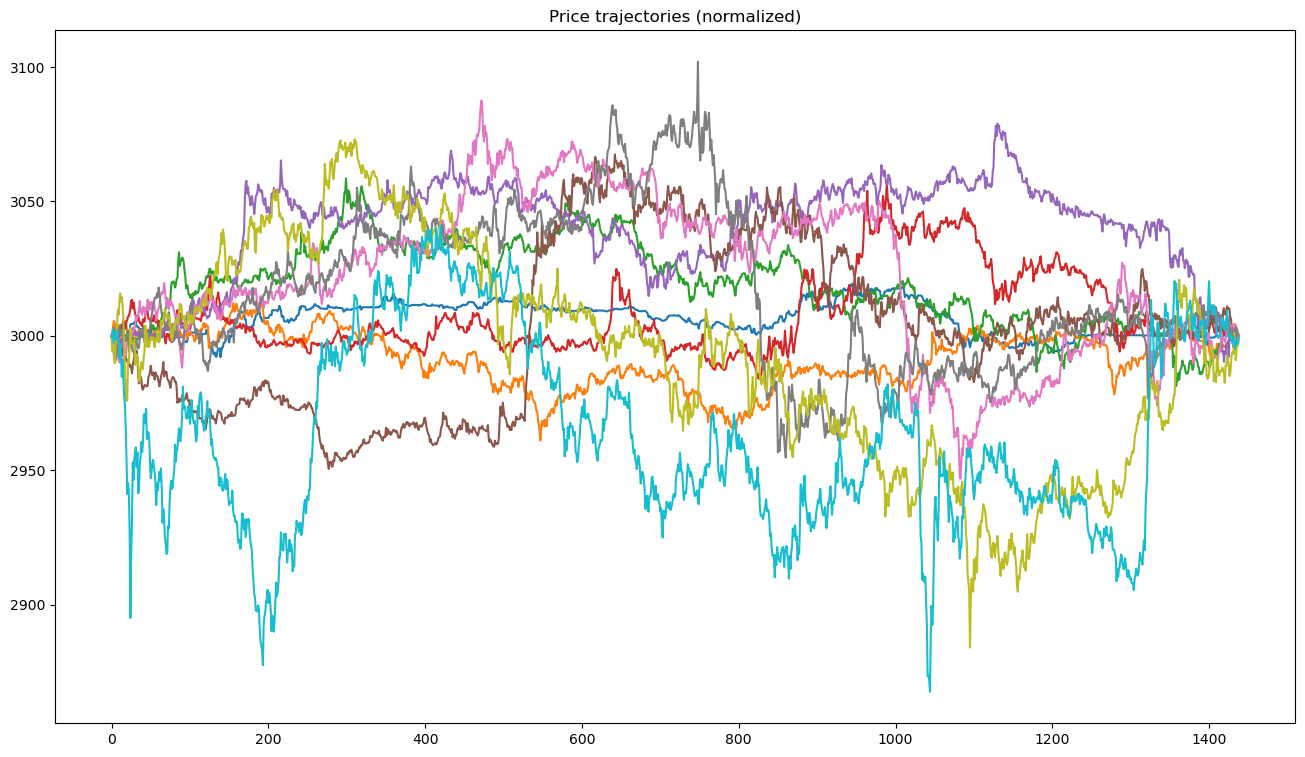

In [15]:
for pa in pas:
    plt.plot(pa[0,:])
plt.title('Price trajectories (normalized)')
plt.show()

In [16]:
# Parallel For Loop Parameters
eta1_vals = np.array([i*0.00025 for i in range(0,101)]) # Set of possible eta values
eta1_vals

array([0.     , 0.00025, 0.0005 , 0.00075, 0.001  , 0.00125, 0.0015 ,
       0.00175, 0.002  , 0.00225, 0.0025 , 0.00275, 0.003  , 0.00325,
       0.0035 , 0.00375, 0.004  , 0.00425, 0.0045 , 0.00475, 0.005  ,
       0.00525, 0.0055 , 0.00575, 0.006  , 0.00625, 0.0065 , 0.00675,
       0.007  , 0.00725, 0.0075 , 0.00775, 0.008  , 0.00825, 0.0085 ,
       0.00875, 0.009  , 0.00925, 0.0095 , 0.00975, 0.01   , 0.01025,
       0.0105 , 0.01075, 0.011  , 0.01125, 0.0115 , 0.01175, 0.012  ,
       0.01225, 0.0125 , 0.01275, 0.013  , 0.01325, 0.0135 , 0.01375,
       0.014  , 0.01425, 0.0145 , 0.01475, 0.015  , 0.01525, 0.0155 ,
       0.01575, 0.016  , 0.01625, 0.0165 , 0.01675, 0.017  , 0.01725,
       0.0175 , 0.01775, 0.018  , 0.01825, 0.0185 , 0.01875, 0.019  ,
       0.01925, 0.0195 , 0.01975, 0.02   , 0.02025, 0.0205 , 0.02075,
       0.021  , 0.02125, 0.0215 , 0.02175, 0.022  , 0.02225, 0.0225 ,
       0.02275, 0.023  , 0.02325, 0.0235 , 0.02375, 0.024  , 0.02425,
       0.0245 , 0.02

CONSTANT SIZE

In [17]:
%%time

optimal_etas = []

for pa in pas:
    output_vals = Parallel(n_jobs=8)(
        delayed(simulation_realprice)(M, N, T, dt, pa, buy, sell, noise, eta0, eta1_vals[j], X, Y) for j in tqdm(range(len(eta1_vals)))
    )
    output_vals = np.array(output_vals)
    pnl = output_vals[:,0]+output_vals[:,1]+output_vals[:,2]+output_vals[:,3]
    
    opteta = eta1_vals[np.argmax(pnl)]
    
    optimal_etas.append(opteta)

  8%|██████████▊                                                                                                                              | 8/101 [00:00<00:02, 45.10it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:03<00:00, 25.78it/s]


CPU times: user 4.38 s, sys: 324 ms, total: 4.71 s
Wall time: 46.5 s


In [18]:
optimal_etas = np.array(optimal_etas)

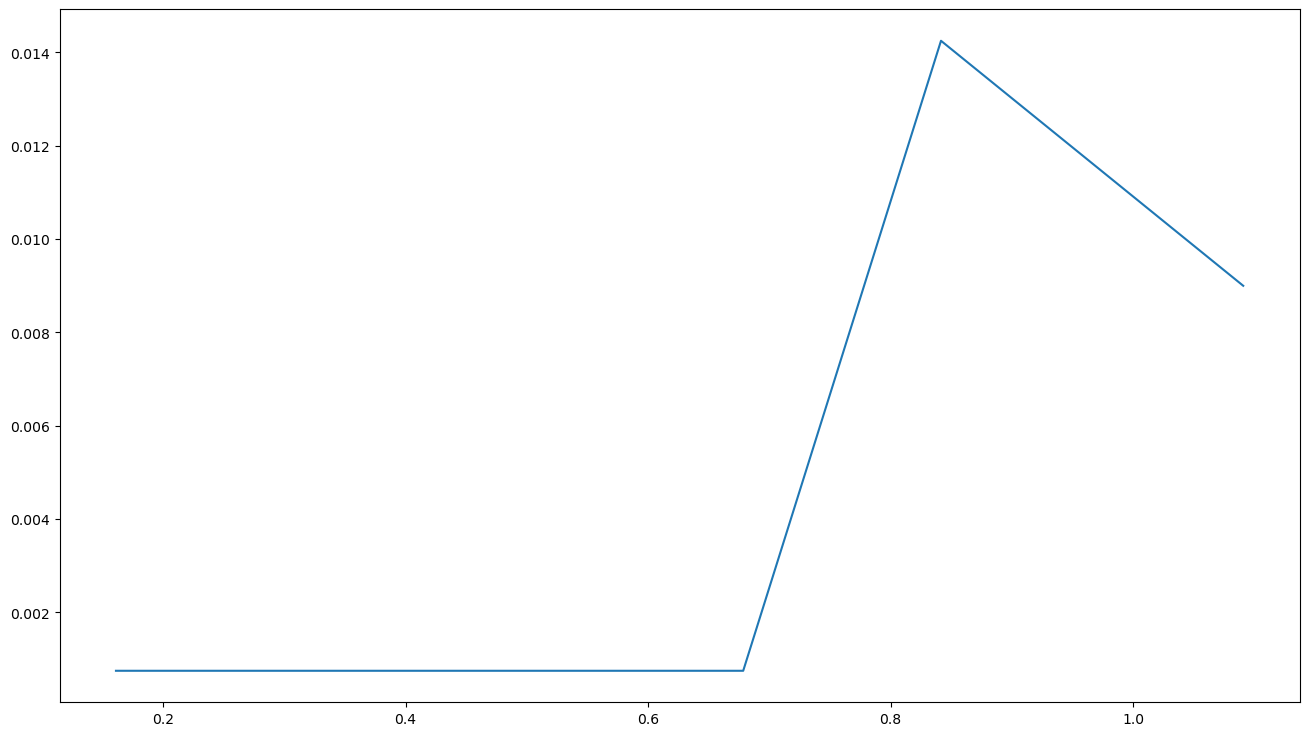

In [20]:
plt.plot(vols, optimal_etas)
plt.show()

SURFACE

In [21]:
%%time

nb_vols = np.shape(vols)[0]

nb_sizes = 51

buys = np.array([50*i*dt for i in range(0,nb_sizes)])
sells = np.array([-50*i*dt for i in range(0,nb_sizes)])

optimal_etas = np.empty((nb_vols, nb_sizes))

for k in range(nb_vols):
    print('------- Vol = %s -------'%vols[k])
    for n in range(nb_sizes):
        
        output_vals = Parallel(n_jobs=8)(
            delayed(simulation_realprice)(M, N, T, dt, pas[k], buys[n], sells[n], noise, eta0, eta1_vals[j], X, Y) for j in tqdm(range(len(eta1_vals)))
        )
        output_vals = np.array(output_vals)
        pnl = output_vals[:,0]+output_vals[:,1]+output_vals[:,2]+output_vals[:,3]

        opteta = eta1_vals[np.argmax(pnl)]

        optimal_etas[k,n] = opteta

------- Vol = 0.1611103714221392 -------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:04<00:00, 24.74it/s]


------- Vol = 0.3145201859990614 -------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:04<00:00, 24.09it/s]


------- Vol = 0.3563998649690691 -------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:04<00:00, 23.45it/s]


------- Vol = 0.4000290128059238 -------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:04<00:00, 23.85it/s]


------- Vol = 0.4690171913121695 -------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:04<00:00, 23.23it/s]


------- Vol = 0.5388339717709161 -------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:04<00:00, 23.19it/s]


------- Vol = 0.5649472130251308 -------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:04<00:00, 23.29it/s]


------- Vol = 0.6784070433684022 -------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:04<00:00, 22.86it/s]


------- Vol = 0.8415248863332094 -------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:04<00:00, 21.07it/s]


------- Vol = 1.0907814615426958 -------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:04<00:00, 23.21it/s]


CPU times: user 3min 48s, sys: 11.2 s, total: 3min 59s
Wall time: 44min 43s


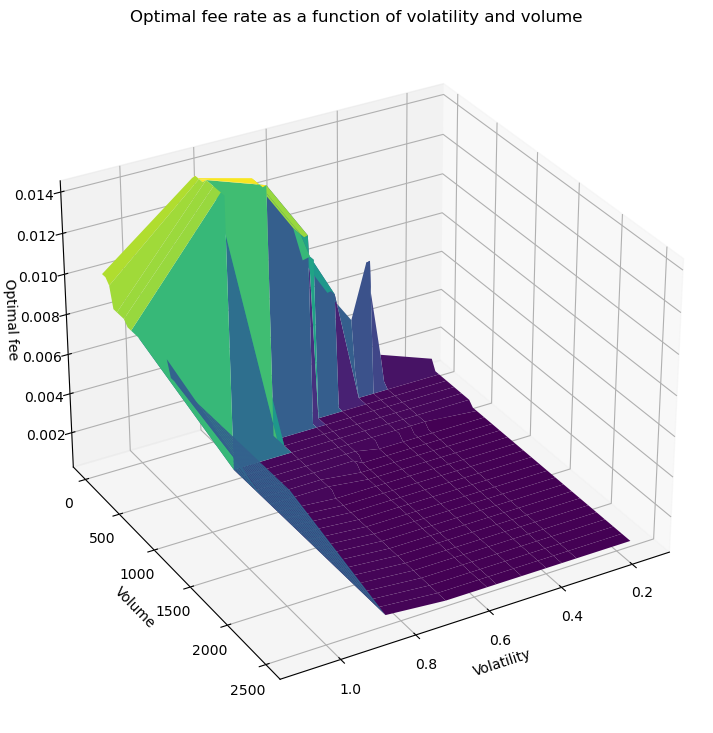

In [25]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(vols, buys/dt)
Z = optimal_etas.T

ax.plot_surface(X, Y, Z, cmap='viridis')

ax.view_init(elev=30, azim=60)

ax.set_xlabel('Volatility')
ax.set_ylabel('Volume')
ax.set_zlabel('Optimal fee')
ax.set_title('Optimal fee rate as a function of volatility and volume')

plt.show()
